# Optimization Study

- stop criteria: 

In [120]:
%config Completer.use_jedi = False

In [135]:
import math
import numpy as np
import pandas as pd
from cmaes import CMA
import seaborn as sns
from scipy.spatial.distance import pdist

## Objective Function

In [42]:
def ackley(x1, x2):
    # https://www.sfu.ca/~ssurjano/ackley.html
    return (
        -20 * math.exp(-0.2 * math.sqrt(0.5 * (x1 ** 2 + x2 ** 2)))
        - math.exp(0.5 * (math.cos(2 * math.pi * x1) + math.cos(2 * math.pi * x2)))
        + math.e + 20
    )

def errorfcn(alpha, Xbar, n, m):
    f1 = np.reshape(alpha[(2 * n):], (m, 2))
    f2 = np.reshape(alpha[0:2 * n], (2, n))
    f3 = Xbar[:, 0:n].T
    r = (Xbar - np.dot(f1, np.dot(f2, f3)).T) ** 2
    return np.nanmean(np.nanmean(r, axis=0))

In [173]:
df = pd.read_csv('datasets/XOR_metadata.csv').drop(columns = ['instances'])
performance_columns = [col for col in df.columns if col.startswith('algo')]
X = df.drop(columns = performance_columns)
Y = df[performance_columns]

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   feature_kDN               1000 non-null   float64
 1   feature_DS                1000 non-null   float64
 2   feature_TD_P              1000 non-null   float64
 3   feature_TD_U              1000 non-null   float64
 4   feature_CLD               1000 non-null   float64
 5   feature_N1                1000 non-null   float64
 6   feature_N2                1000 non-null   float64
 7   feature_LSR               1000 non-null   float64
 8   feature_Harmfulness       1000 non-null   float64
 9   feature_Usefulness        1000 non-null   float64
 10  algo_bagging              1000 non-null   float64
 11  algo_dummy                1000 non-null   float64
 12  algo_gradient_boosting    1000 non-null   float64
 13  algo_logistic_regression  1000 non-null   float64
 14  algo_mlp 

## IPOP-CMA-ES

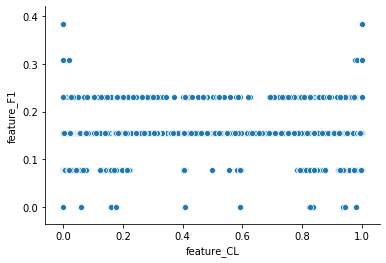

In [164]:
sns.scatterplot(x = X['feature_CL'], y = X['feature_F1'])
sns.despine()

In [175]:
Xbar = np.hstack((X, Y))
n = X.shape[1]
m = Xbar.shape[1]

search_space = 1#32.768
bounds = list()
bounds.append([[-search_space, search_space] for i in range(2 * m + 2 * n)])
bounds = np.array(bounds).reshape((2 * m + 2 * n, 2))

lower_bounds, upper_bounds = bounds[:, 0], bounds[:, 1]
mean = lower_bounds + (np.random.rand(2 * m + 2 * n) * (upper_bounds - lower_bounds))
sigma = search_space * 2 / 5  # 1/5 of the domain width

optimizer = CMA(mean=mean, sigma=sigma, bounds=bounds, seed=0)

ntries = 30
perf = np.zeros(ntries)
alpha = np.zeros((2 * m + 2 * n, ntries))
Hd = pdist(X)[np.newaxis].T

for generation in range(ntries):
    solutions = []
    
    for _ in range(optimizer.population_size):
        # Sample parameters to evaluate function
        alpha[:, generation] = optimizer.ask()
        
        # Calculate function value
        value = errorfcn(alpha = alpha[:, generation], Xbar = Xbar, n = n, m = m)
        solutions.append((alpha[:, generation], value))
    
#     print(f"#{generation} {value}")
    optimizer.tell(solutions)
#     print('shape alpha', alpha.shape, "alpha\n", alpha)
    aux = alpha[:, [generation]]
    A = np.reshape(aux[0:2 * n], (2, n))
    Z = np.dot(X, A.T)
    perf[generation] = np.corrcoef(Hd, pdist(Z)[np.newaxis].T, rowvar=False)[0][1]
    
    # Restart
    if optimizer.should_stop():
        print('Optimizer should stop')
        # popsize multiplied by 2 (or 3) before each restart.
        popsize = optimizer.population_size * 2
        
        mean = lower_bounds + (np.random.rand(2 * m + 2 * n) * (upper_bounds - lower_bounds))
        optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize)
        print(f"Restart CMA-ES with popsize={popsize}")
    
idx = np.argmax(perf)
A = np.reshape(alpha[0:2 * n, idx], (2, n))
Z = np.dot(X, A.T)
B = np.reshape(alpha[(2 * n):, idx], (m, 2))
Xhat = np.dot(Z, B.T)
C = B[n:m + 1, :].T
B = B[0:n + 1, :]
error = np.sum((Xbar - Xhat) ** 2)

In [176]:
error

64481.93975076464

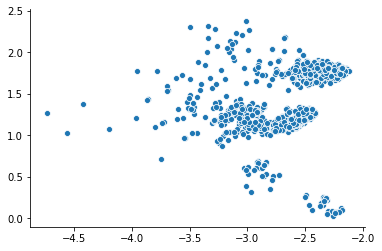

In [177]:
sns.scatterplot(x = Z[:, 0], y = Z[:, 1])
sns.despine()

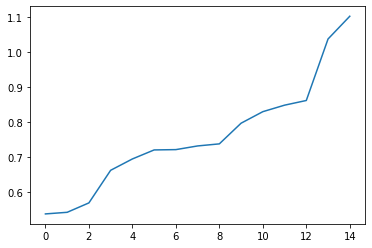

In [167]:
function_values = [s[1] for s in solutions] 

sns.lineplot(x = [i for i in range(len(function_values))],
             y = function_values)

## BIPOP-CMA-ES

In [32]:
Xbar = np.hstack((X, Y))
n = X.shape[1]
m = Xbar.shape[1]

search_space = 1#32.768
bounds = list()
bounds.append([[-search_space, search_space] for i in range(2 * m + 2 * n)])
bounds = np.array(bounds).reshape((2 * m + 2 * n, 2))

lower_bounds, upper_bounds = bounds[:, 0], bounds[:, 1]
mean = lower_bounds + (np.random.rand(2 * m + 2 * n) * (upper_bounds - lower_bounds))
sigma = search_space * 2 / 5  # 1/5 of the domain width

optimizer = CMA(mean=mean, sigma=sigma, bounds=bounds, seed=0)

ntries = 30
perf = np.zeros(ntries)
alpha = np.zeros((2 * m + 2 * n, ntries))
Hd = pdist(X)[np.newaxis].T

n_restarts = 0  # A small restart doesn't count in the n_restarts
small_n_eval, large_n_eval = 0, 0
popsize0 = optimizer.population_size
inc_popsize = 2

# Initial run is with "normal" population size; it is
# the large population before first doubling, but its
# budget accounting is the same as in case of small
# population.
poptype = "small"

for generation in range(10):
    solutions = []
    for _ in range(optimizer.population_size):
        x = optimizer.ask()
        value = ackley(x[0], x[1])
        solutions.append((x, value))
        print(f"#{generation} {value} (x1={x[0]}, x2 = {x[1]})")
    optimizer.tell(solutions)

    if optimizer.should_stop():
        n_eval = optimizer.population_size * optimizer.generation
        if poptype == "small":
            small_n_eval += n_eval
        else:  # poptype == "large"
            large_n_eval += n_eval

        if small_n_eval < large_n_eval:
            poptype = "small"
            popsize_multiplier = inc_popsize ** n_restarts
            popsize = math.floor(
                popsize0 * popsize_multiplier ** (np.random.uniform() ** 2)
            )
        else:
            poptype = "large"
            n_restarts += 1
            popsize = popsize0 * (inc_popsize ** n_restarts)

        mean = lower_bounds + (np.random.rand(2) * (upper_bounds - lower_bounds))
        optimizer = CMA(
            mean=mean,
            sigma=sigma,
            bounds=bounds,
            population_size=popsize,
        )
        print("Restart CMA-ES with popsize={} ({})".format(popsize, poptype))

#0 0.528235329174902 (x1=6.139172164391592, x2 = 5.61093683521669)
#0 -6.445325647637464 (x1=2.4692938738940797, x2 = 8.914619521531543)
#0 -4.054158803236985 (x1=4.645256496422147, x2 = 8.699415299659131)
#0 -6.182454387120107 (x1=-0.07878898960467229, x2 = 6.103665397515435)
#0 -4.424703273866822 (x1=2.126684999229745, x2 = 6.551388273096567)
#0 4.045373043414878 (x1=7.747958699742153, x2 = 3.702585656327275)
#1 -6.400856242843519 (x1=1.1385767723684803, x2 = 7.5394330152119995)
#1 -7.087231787295645 (x1=2.2297537165380965, x2 = 9.316985503833742)
#1 -1.241512249257283 (x1=-0.7644744447685636, x2 = 0.47703780448871935)
#1 -4.481722219554313 (x1=3.022958160353115, x2 = 7.504680379907428)
#1 -4.174580515222187 (x1=2.0071754058262923, x2 = 6.18175592104848)
#1 -0.5558489938637972 (x1=1.032263421209032, x2 = 1.5881124150728292)
#2 -6.460073379344831 (x1=3.383394334923237, x2 = 9.843467714268067)
#2 -4.083503053574978 (x1=5.586024069317931, x2 = 9.669527122892909)
#2 -8.125121255404373 (x

In [33]:
solutions

[(array([-8.48988342,  9.66471482]), -18.154598237888205),
 (array([-9.38391212,  7.50638801]), -16.89030012962114),
 (array([-6.78880738,  9.19174201]), -15.980549385937206),
 (array([-6.56286166,  9.24397185]), -15.806833515286858),
 (array([-8.80715699,  6.91442432]), -15.721581305921411),
 (array([-6.21155628,  3.78696202]), -9.998518303423223)]